# Taller de visión por ordenador aplicado a la apicultura

## Importar librerías

In [1]:
#!pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
import cv2
%matplotlib inline

## Análisis de Imágenes

Cargamos la foto con la función de la librería de opencv. Hay que tener en cuenta que opencv trabaja en **BGR**.

In [3]:
name = "1"
img = cv2.imread("fotos/"+name+'.png')

Definimos una función para mostar las imágenes.

In [4]:
def show_img(img, title='img', inline=True):
    if inline == True:
        aux = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(aux)
    else:
        cv2.imshow(title, img)
        cv2.waitKey()
        cv2.destroyAllWindows()

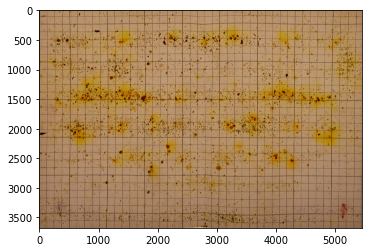

In [5]:
show_img(img)

### Procesado

#### Visualizar gráficas

In [6]:
def calcHistogram(img, canal=0):
    height = 0
    width = 0
    gray = False
    try:
        height, width, channels = img.shape
    except ValueError:
        height, width = img.shape
        gray = True
    histArray =  []
    for x in range(255):
        histArray.append(0)
    for i in range(height):
        for j in range(width):
            if gray:
                histArray[int(img.item(i,j))] += 1
            else:
                histArray[int(img.item(i,j,canal))] += 1
    return histArray

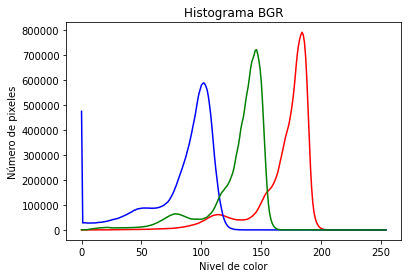

In [7]:
histRed = calcHistogram(img, 2)
plt.plot(histRed, color='red')
histBlue = calcHistogram(img, 0)
plt.plot(histBlue, color='blue')
histGreen = calcHistogram(img, 1)
plt.plot(histGreen, color='green')
plt.title("Histograma BGR")
plt.xlabel("Nivel de color")
plt.ylabel("Número de pixeles")
plt.show()

#### Extraer canal rojo

Ponemos a cero todos los canales excepto el rojo, para así resaltar los puntos mas rojizos, ya que las varroas tienen una tonalidad roja.

In [8]:
red = img.copy()
red[:,:,0] = 0
red[:,:,1] = 0

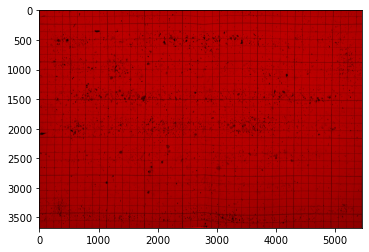

In [9]:
show_img(red)

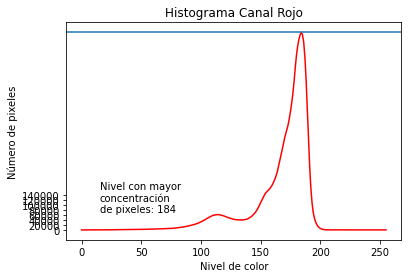

In [10]:
opencvHistRed = cv2.calcHist([img],[2], None, [256],[0,256])
plt.plot(opencvHistRed, color='red')
plt.xlabel("Nivel de color")
plt.ylabel("Número de pixeles")
plt.title("Histograma Canal Rojo")
idmax = np.argmax(opencvHistRed, axis=0)[0]
plt.text(15, 70000, "Nivel con mayor\nconcentración\nde pixeles: "+str(idmax))
plt.axhline(max(opencvHistRed))
plt.yticks(range(0,160000, 20000))
plt.show()

In [11]:
print("Nivel con mayor concentración de pixeles: "+str(idmax))

Nivel con mayor concentración de pixeles: 184


#### Binarizar

##### Algoritmo del mínimo error de Kittler e Illingworth.

Método de umbralización de imagenes, es decir, bsuqueda del umbral óptimo que permita separar los objetos de primer plano del fondo.

<img src="imgs/formulas_1.PNG"/>
<img src="imgs/formulas_2.PNG"/>

In [12]:
def kittler(im, out):
    """Algoritmo de Mínimo Error de Kittler e Illingworth


    Arguments:
    im -- imagen en escala de grises
    out -- kernel donde estará la imagen de salida
    """

    np.seterr(divide='ignore', invalid='ignore')
    h, g = np.histogram(im.ravel(), 256, [0, 256])
    h = h.astype(np.float)
    g = g.astype(np.float)
    g = g[:-1]
    c = np.cumsum(h)
    m = np.cumsum(h * g)
    s = np.cumsum(h * g**2)
    sigma_f = np.sqrt(s/c - (m/c)**2)
    cb = c[-1] - c
    mb = m[-1] - m
    sb = s[-1] - s
    sigma_b = np.sqrt(sb/cb - (mb/cb)**2)
    p = c / c[-1]
    v = p * np.log(sigma_f) + (1-p)*np.log(sigma_b) - \
        p*np.log(p) - (1-p)*np.log(1-p)
    v[~np.isfinite(v)] = np.inf
    idx = np.argmin(v)
    t = g[idx]
    out[:, :] = 0
    out[im >= t] = 255

A partir de la imagen con el canal rojo aislado, binarizamos la imagen

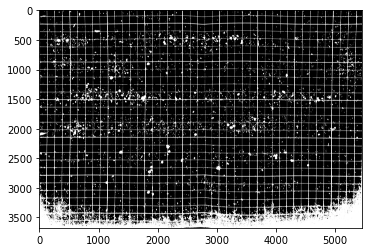

In [13]:
kernel = np.ones((5, 5), np.uint8)
dilation = cv2.dilate(red, kernel, iterations=1)
erosion = cv2.erode(dilation, kernel, iterations=1)
median = cv2.medianBlur(erosion, 3)
gray = cv2.cvtColor(erosion, cv2.COLOR_BGR2GRAY)
out = np.empty_like(gray)
kittler(gray, out)
out = cv2.bitwise_not(out)
show_img(out)

#### Eliminar las lineas

##### Algoritmo Canny

In [14]:
def canny(img):
    dst = cv2.Canny(img, 50, 200, None, 3)
    res = out.copy()

    linesP = cv2.HoughLinesP(dst, 1, np.pi / 180, 50, None, 50, 10)

    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv2.line(res, (l[0], l[1]), (l[2], l[3]), (0,0,0), 10, cv2.LINE_AA)
        
    return res

In [15]:
res = canny(out)

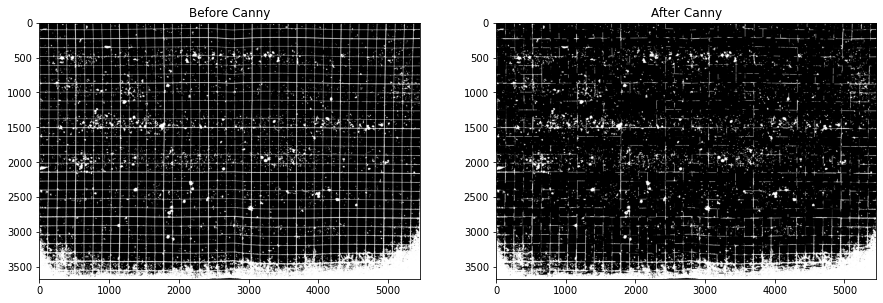

In [16]:
f = plt.figure(figsize=(15,10))
f.add_subplot(1,2, 1)
plt.title("Before Canny")
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
f.add_subplot(1,2, 2)
plt.title("After Canny")
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
plt.show(block=True)

#### Obtener los contornos

In [17]:
cont, jer = cv2.findContours(res, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

#### Dibujar los contornos

In [18]:
draw_org = img.copy()
_ = cv2.drawContours(draw_org, cont, -1, (0, 0, 255), 2, cv2.LINE_AA)

In [19]:
draw = res.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
_ = cv2.drawContours(draw, cont, -1, (0, 255, 0), 2, cv2.LINE_AA)

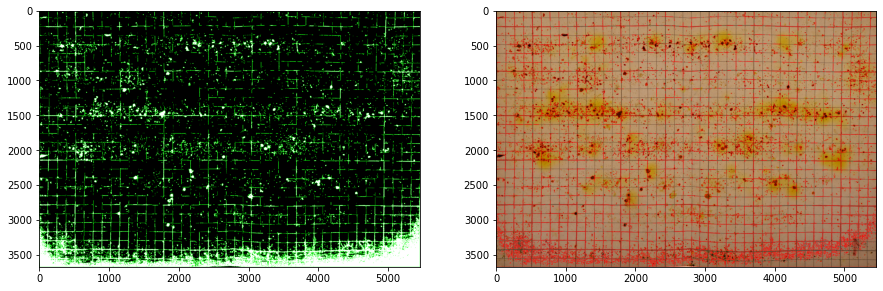

In [20]:
f = plt.figure(figsize=(15,10))
f.add_subplot(1,2, 1)
plt.imshow(cv2.cvtColor(draw, cv2.COLOR_BGR2RGB))
f.add_subplot(1,2, 2)
plt.imshow(cv2.cvtColor(draw_org, cv2.COLOR_BGR2RGB))
plt.show(block=True)

### Extracción de Caracteríasticas

#### Coordenadas

In [21]:
cont_x = []
cont_y = []

for c in cont:
    grain = np.int0(cv2.boxPoints(cv2.minAreaRect(c)))
    centroid = (grain[2][1]-(grain[2][1]-grain[0][1])//2,
                grain[2][0]-(grain[2][0]-grain[0][0])//2)
    cont_x.append(centroid[0])    
    cont_y.append(centroid[1])

#### Área

In [22]:
cont_areas = []

for c in cont:
    area = cv2.contourArea(c)
    cont_areas.append(area)

#### Excentricidad

In [23]:
cont_exc = []

pi_4 = np.pi*4

for c in cont:
    if len(c) > 5:
        area = cv2.contourArea(c)
        arclen = cv2.arcLength(c, True)
        ellipse = cv2.fitEllipse(c)# ((centroX, centroY), (semiejeMenor, semiejeMayor), anguloRotacion)
        exEl = math.sqrt(
            (ellipse[1][1]*ellipse[1][1])-(ellipse[1][0]*ellipse[1][0]))/ellipse[1][1]
        cont_exc.append(exEl)
    else:
        cont_exc.append(0)

#### Semiejes de la Elipse

In [24]:
cont_minor_axis = []
cont_major_axis = []

pi_4 = np.pi*4

for c in cont:
    if len(c) > 5:
        area = cv2.contourArea(c)
        arclen = cv2.arcLength(c, True)
        ellipse = cv2.fitEllipse(c)# ((centroX, centroY), (semiejeMenor, semiejeMayor), anguloRotacion)
        minor = ellipse[1][0]
        major = ellipse[1][1]
        cont_minor_axis.append(minor)
        cont_major_axis.append(major)
    else:
        cont_minor_axis.append(0)
        cont_major_axis.append(0)

#### Color

In [25]:
cont_red = []
cont_green = []
cont_blue = []

for c in cont:
    grain = np.int0(cv2.boxPoints(cv2.minAreaRect(c)))
    centroid = (grain[2][1]-(grain[2][1]-grain[0][1])//2,
                grain[2][0]-(grain[2][0]-grain[0][0])//2)
    color = img[centroid]
    cont_blue.append(color[0])
    cont_green.append(color[1])
    cont_red.append(color[2])

### Crear Dataset

In [26]:
data = {"x":cont_x, "y":cont_y, "area":cont_areas , "excentricidad": cont_exc, 
        "semieje_menor":cont_minor_axis, "semieje_mayor":cont_major_axis,
        "azul":cont_blue, "verde":cont_green, "rojo":cont_red}
for i in data:
    print(i + ": " + str(len(data[i])))

x: 9683
y: 9683
area: 9683
excentricidad: 9683
semieje_menor: 9683
semieje_mayor: 9683
azul: 9683
verde: 9683
rojo: 9683


In [27]:
df = pd.DataFrame(data)
df.head()

,x,y,area,excentricidad,semieje_menor,semieje_mayor,azul,verde,rojo
0,3435,3387,80.5,0.772187,9.388046,14.775128,33,97,132
1,3427,3238,38.5,0.711256,6.578840,9.359131,2,22,77
2,3424,3378,36.0,0.882277,5.362664,11.392221,83,121,156
3,3418,2072,16.0,0.000000,0.000000,0.000000,17,54,104
4,3417,2536,27.0,0.782265,5.697639,9.146276,30,94,135


In [28]:
df.describe()

,x,y,area,excentricidad,semieje_menor,semieje_mayor,azul,verde,rojo
count,9683.000000,9683.000000,9.683000e+03,9683.000000,9683.000000,9683.000000,9683.000000,9683.000000,9683.000000
mean,2331.173500,2761.712176,5.422917e+02,0.428951,8.362950,32.819723,50.928948,88.829805,133.703501
std,1160.535267,1551.116390,2.830142e+04,0.397784,35.561976,1060.003540,39.348560,38.754527,31.913832
min,1.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
25%,1374.000000,1432.500000,4.000000e+00,0.000000,0.000000,0.000000,4.000000,58.000000,113.000000
50%,2500.000000,2846.000000,2.000000e+01,0.577350,3.162278,4.000000,60.000000,106.000000,149.000000
75%,3481.000000,4028.000000,6.250000e+01,0.802318,7.866138,14.229372,89.000000,121.000000,159.000000
max,3672.000000,5458.000000,2.778832e+06,1.000000,1948.802612,96078.265625,127.000000,164.000000,201.000000


In [29]:
df.to_csv("datasets/image_1.csv")

*Realizamos el etiquitado manual*

## Análisis de los datos

### Cargamos el dataset etiquetado

In [30]:
df = pd.read_csv("datasets/image_1_with_target.csv", index_col=0)

In [31]:
df.head()

,x,y,area,excentricidad,semieje_menor,semieje_mayor,azul,verde,rojo,clase
0,3435,3387,80.5,0.772187,9.388046,14.775128,33,97,132,0
1,3427,3238,38.5,0.711256,6.578840,9.359131,2,22,77,0
2,3424,3378,36.0,0.882277,5.362664,11.392221,83,121,156,0
3,3418,2072,16.0,0.000000,0.000000,0.000000,17,54,104,0
4,3417,2536,27.0,0.782265,5.697639,9.146276,30,94,135,0


### Gráficos

In [32]:
count = df.groupby(df.clase).count().x.values

([<matplotlib.axis.XTick at 0x1e9003629d0>,
 [Text(0, 0, ''), Text(0, 0, '')])

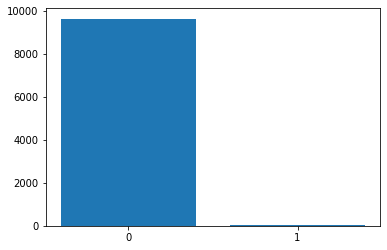

In [33]:
plt.bar([0,1], count)
plt.xticks([0,1])

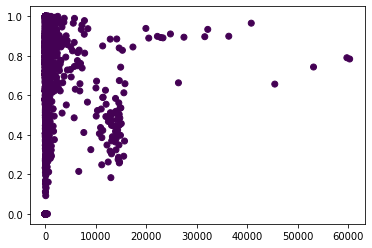

In [34]:
plt.scatter(df.area, df.excentricidad, c=df.clase)

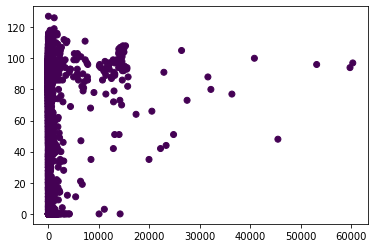

In [35]:
plt.scatter(df.area, df.azul, c=df.clase)

### SVM

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix, classification_report

In [37]:
X = df.drop(["x","y","clase"], axis=1)
y = df["clase"]

In [38]:
std = StandardScaler()
X_std = std.fit_transform(X)
X_std = pd.DataFrame(X_std, columns=X.columns)

In [39]:
X_std.head()

,area,excentricidad,semieje_menor,semieje_mayor,azul,verde,rojo
0,-0.091559,0.863073,0.041413,-0.016525,-0.455542,0.210981,-0.053240
1,-0.113553,0.709885,-0.053517,-0.021641,-1.243465,-1.724465,-1.776802
2,-0.114862,1.139854,-0.094614,-0.019721,0.815300,0.830324,0.698860
3,-0.125336,-1.078311,-0.275831,-0.030482,-0.862212,-0.898674,-0.930690
4,-0.119575,0.888409,-0.083295,-0.021842,-0.531793,0.133563,0.040772


In [40]:
X_std.describe()

,area,excentricidad,semieje_menor,semieje_mayor,azul,verde,rojo
count,9.682000e+03,9.682000e+03,9.682000e+03,9.682000e+03,9.682000e+03,9.682000e+03,9.682000e+03
mean,8.806561e-18,-2.641968e-17,-3.669401e-17,-5.412366e-18,5.871041e-17,-2.230996e-16,-4.227150e-16
std,1.000052e+00,1.000052e+00,1.000052e+00,1.000052e+00,1.000052e+00,1.000052e+00,1.000052e+00
min,-1.337146e-01,-1.078311e+00,-2.758311e-01,-3.048225e-02,-1.294298e+00,-2.292195e+00,-3.563039e+00
25%,-1.316199e-01,-1.078311e+00,-2.758311e-01,-3.048225e-02,-1.192631e+00,-7.954506e-01,-6.486525e-01
50%,-1.232410e-01,3.732264e-01,-1.689703e-01,-2.670373e-02,2.307126e-01,4.432348e-01,4.794973e-01
75%,-1.009847e-01,9.386988e-01,-1.011021e-02,-1.704578e-02,9.678013e-01,8.303240e-01,7.928723e-01
max,3.144483e+01,1.435826e+00,4.352811e+01,9.072776e+01,1.933642e+00,1.939980e+00,2.109047e+00


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=30)

In [42]:
svc = SVC(class_weight="balanced")
svc.fit(X_train, y_train)

SVC(class_weight='balanced')

In [43]:
svc.score(X_test,y_test)

0.7305110996386164

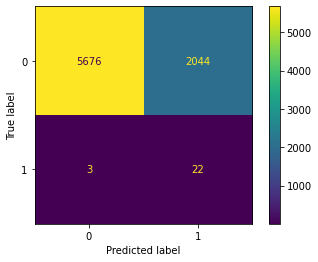

In [44]:
plot_confusion_matrix(svc, X_train, y_train)

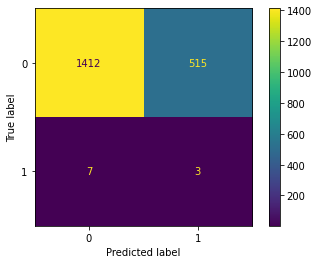

In [45]:
plot_confusion_matrix(svc, X_test, y_test)

In [46]:
classification_report(y_test, svc.predict(X_test))

'              precision    recall  f1-score   support\n\n           0       1.00      0.73      0.84      1927\n           1       0.01      0.30      0.01        10\n\n    accuracy                           0.73      1937\n   macro avg       0.50      0.52      0.43      1937\nweighted avg       0.99      0.73      0.84      1937\n'

### Random Forest

In [47]:
from sklearn.ensemble import RandomForestClassifier

In [48]:
clf = RandomForestClassifier(max_depth=2, random_state=0, class_weight="balanced")

In [49]:
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=2, random_state=0)

In [50]:
clf.score(X_test,y_test)

0.719153329891585

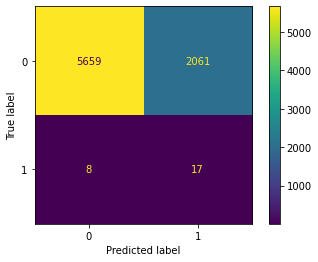

In [51]:
plot_confusion_matrix(clf, X_train, y_train)

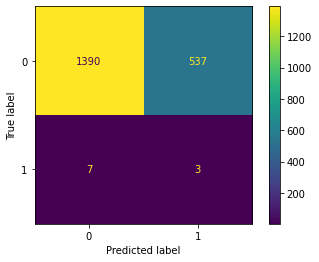

In [52]:
plot_confusion_matrix(clf, X_test, y_test)

In [53]:
classification_report(y_test, clf.predict(X_test))

'              precision    recall  f1-score   support\n\n           0       0.99      0.72      0.84      1927\n           1       0.01      0.30      0.01        10\n\n    accuracy                           0.72      1937\n   macro avg       0.50      0.51      0.42      1937\nweighted avg       0.99      0.72      0.83      1937\n'

### XGBoost

In [54]:
import xgboost as xgb

In [55]:
xgbcl = xgb.XGBClassifier()
xgbcl.fit(X_train, y_train)

c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:53:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [56]:
xgbcl.score(X_test, y_test)

0.9943211151264842

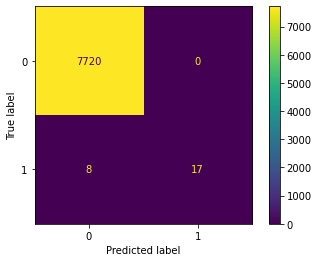

In [57]:
plot_confusion_matrix(xgbcl, X_train, y_train)

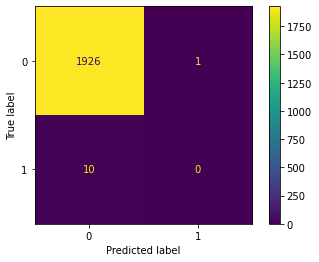

In [58]:
plot_confusion_matrix(xgbcl, X_test, y_test)

In [59]:
classification_report(y_train, xgbcl.predict(X_train))

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00      7720\n           1       1.00      0.68      0.81        25\n\n    accuracy                           1.00      7745\n   macro avg       1.00      0.84      0.90      7745\nweighted avg       1.00      1.00      1.00      7745\n'

### Neural Network

In [60]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [61]:
from keras.models import Sequential
from keras.layers import Dense

In [71]:
nn = Sequential()
nn.add(Dense(512, input_dim=7, activation='relu'))
nn.add(Dense(7, activation='relu'))
nn.add(Dense(1, activation='sigmoid'))

In [72]:
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC()])

In [73]:
nn.fit(X_train, y_train, epochs=150, batch_size=10)

Epoch 1/150
775/775 [==============================] - 5s 6ms/step - loss: 0.0851 - auc_1: 0.4866
Epoch 2/150
775/775 [==============================] - 5s 6ms/step - loss: 0.0161 - auc_1: 0.5886A: 1s - lo
Epoch 3/150
775/775 [==============================] - 4s 6ms/step - loss: 0.0224 - auc_1: 0.5392
Epoch 4/150
775/775 [==============================] - 4s 6ms/step - loss: 0.0215 - auc_1: 0.5790
Epoch 5/150
775/775 [==============================] - 5s 6ms/step - loss: 0.0170 - auc_1: 0.5266
Epoch 6/150
775/775 [==============================] - 5s 6ms/step - loss: 0.0250 - auc_1: 0.5762
Epoch 7/150
775/775 [==============================] - 4s 6ms/step - loss: 0.0154 - auc_1: 0.5097
Epoch 8/150
775/775 [==============================] - 4s 5ms/step - loss: 0.0184 - auc_1: 0.6211
Epoch 9/150
775/775 [==============================] - 4s 6ms/step - loss: 0.0196 - auc_1: 0.5578
Epoch 10/150
775/775 [==============================] - 4s 5ms/step - loss: 0.0206 - auc_1: 0.5986
Epoch 11/

775/775 [==============================] - 4s 6ms/step - loss: 0.0291 - auc_1: 0.7377
Epoch 84/150
775/775 [==============================] - 4s 5ms/step - loss: 0.0122 - auc_1: 0.6326
Epoch 85/150
775/775 [==============================] - 4s 5ms/step - loss: 0.0184 - auc_1: 0.7895
Epoch 86/150
775/775 [==============================] - 4s 5ms/step - loss: 0.0197 - auc_1: 0.7148
Epoch 87/150
775/775 [==============================] - 4s 5ms/step - loss: 0.0183 - auc_1: 0.7777
Epoch 88/150
775/775 [==============================] - 4s 6ms/step - loss: 0.0167 - auc_1: 0.6018A: 0s - loss: 0.0165 - auc_1
Epoch 89/150
775/775 [==============================] - 4s 5ms/step - loss: 0.0187 - auc_1: 0.6952
Epoch 90/150
775/775 [==============================] - 4s 5ms/step - loss: 0.0212 - auc_1: 0.6826
Epoch 91/150
775/775 [==============================] - 4s 5ms/step - loss: 0.0211 - auc_1: 0.7068
Epoch 92/150
775/775 [==============================] - 4s 5ms/step - loss: 0.0144 - auc_1: 0.

In [74]:
nn.evaluate(X_test, y_test)

61/61 [==============================] - 1s 4ms/step - loss: 0.0508 - auc_1: 0.4956


[0.050834838300943375, 0.4955630898475647]